![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

# Fire Radiative Power and Active Fire

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-land/develop?labpath=fire-radiative-power-and-active-fire.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-radiative-power-and-active-fire.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-radiative-power-and-active-fire.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-radiative-power-and-active-fire.ipynb)

## Learning objectives 🎯

This dataset provides a set of active fire (AF) and fire radiative power (FRP) products derived from observations made by the Sea and Land Surface Temperature Radiometer (SLSTR) operating concurrently onboard the European Sentinel-3 satellites, currently S3A and S3B. These products are generated from the non-time critical (NTC) Level 2 AF detection and FRP product from European Space Agency (ESA). The AF, FRP and the Burnt Areas are Essential Climate Variables (ECV) from the Global Observing System for Climate (GCOS). Burnt Area is provided through a different catalogue entry.

The AF and the FRP products encompass a Level 2 summary product which provides a text-based table summary of the Level 2 AF detection and FRP data collected over the period of one month across the globe. In addition, three gridded Level 3 ‘synthesis products’ are also provided. Each synthesis product grids the Level 2 AF and FRP data at various spatial and temporal resolutions, and provides information for including or removing adjustments for cloud cover that blocks the fires from the satellite sensors view. The following gridded products are available:

- daily global Level 3 FRP product generated on a global 0.1 degree resolution grid. AF data coming from observations made by both Sentinel-3A (S3A) and -3B (S3B) have separate layers in this product. have separate layers in this product. Initially only night-time land observations were included, with the full daytime dataset provided subsequently once the corresponding NTC Level 2 FRP data became available.
- 27 day global Level 3 FRP product also derived at 0.1 degree grid cell resolution but summarising the FRP data from both Sentinel-3A and -3B. This time period matches the Sentinel-3 satellites standard orbital repeat cycle.
- monthly global Level 3 FRP product which provides global AF detection and FRP data at a grid cell size of 0.25 degrees. This resolution matches the MODIS Climate Modelling Grid (CMG) active fire product.

The purpose of these AF and FRP products is to provide a summarised and 'easy to use' version of the Level 2 AF and FRP products, as well as providing the AF and FRP information in a consistently gridded format. The latter in particular is designed to be suitable for use in global modelling, trend analysis and model evaluation.

These AF and FRP were produced on behalf of the Copernicus Climate Change Service and have been designed to be broadly comparable with the equivalent Fire Burnt Area product, since some applications maybe likely to use them in combination.

![logo](./img/overview_FRP.png)

**References:**
- Freeborn, P.H., Cochrane, M.A. and Wooster, M.J., 2014. A decade long, multi-scale map comparison of fire regime parameters derived from three publically available satellite-based fire products: A case study in the Central African Republic. Remote Sensing, 6(5), pp.4061-4089.
- Silva, P., Carmo, M., Rio, J. and Novo, I., 2023. Changes in the seasonality of fire activity and fire weather in Portugal: is the wildfire season really longer? Meteorology, 2(1), pp.74-86.

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

The following code block will import the python modules required for this notebook. We will be using earthkit-data and xarray for handling the data, and matplotlib and cartopy for plotting. The code block also includes a command to install earthkit-data form pip.

In [ ]:
import os

# Modules related to data retrieving
!pip install -q "earthkit-data[all]"
import earthkit as ek
import cdsapi

# Modules related to plot and EO data manipulation
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

### Specify data directory

Below we define a directory to store the files locally, and create this directory if it does not already exist

In [ ]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

The Copernicus Climate Change Service (C3S) provides Intermediate Climate Data Records (ICDRs) for many Essential Climate Variables (ECVs), amongst which is active fire (AF) and fire radiative power (FRP) - [[C3S Fire AF & FRP dataset](https://cds.climate.copernicus.eu/datasets/satellite-fire-radiative-power?tab=overview)]. The C3S AF & FRP products are generated from observations made by the Sea and Land Surface Temperature Radiometer (SLSTR) operating onboard the Sentinel-3 satellites, currently (2023) Sentinel-3A and Sentinel-3B.

Sentinel-3 SLSTR Level 1 data are used to generate a set of granule-based Level 2 Active Fire (AF) Detection and FRP products that each store essential information about pixels believed to contain actively burning fires identified in each 3 minute Universal Time SLSTR Level 1 granule, including their location, fire radiative power (FRP in MW) and FRP uncertainty, along with a SUMMARY FLAG dataset providing information on every pixel in the granule related primarily to the output of the active fire detection tests. These SUMMARY FLAG data are stored as a 2D array bit mask. Each Level 2 FRP product corresponds to a single SLSTR data granule and contains a very large amount of information across a set of eleven measurement and annotation data files, plus an XML manifest (xfdumanifest.xml) that describes the content and metadata of the package. The manifest is the entry point for accessing and processing the package. Whilst these Level 2 FRP product files are extremely comprehensive in the information they contain, use of them at the global scale and over long time periods results in potentially very large numbers of data files. Therefore, the C3S FRP products provide both a Level 2 global summary FRP product that provides a text-based summary of the Level 2 Active Fire Detection and FRP product data collected over the period of one month at the locations of all detected active fire (AF) pixels, plus three Level 3 ‘synthesis products’ which summarize the Level 2 AF detection and FRP data at various spatial and temporal resolutions,  and provide some adjustments for cloud cover variations. These C3S products are designed for ease of access and use of the key information held within the Level 2 granule-based FRP products, and for global modelling, trend analysis and model evaluation. 

                             
|   DATA  | DESCRIPTION|
| :---: | :---:|                                                                                                                                                                  
|**Data type** | 	Gridded for the gridded product <br> Point data for the summary product|
|**Horizontal coverage** | 	Global|
|**Horizontal resolution** |	0.1°x 0.1° and 0.25°x 0.25° for the gridded product <br> Point data (based on 1km observations) for the summary product|
|**Vertical coverage** | Surface|
|**Vertical resolution** | Single level|
|**Temporal coverage** | From March 2020 to present|
|**Temporal resolution** |	Daily, 27 days (Sentinel-3 repeat cycle) and monthly for the gridded product <br> Individual time stamps of active fire events, monthly files for the summary product |
|**File format**	| NetCDF4 for the gridded product  <br>  CSV for the summary product|
|**Conventions**	| Climate and Forecast (CF) Metadata Convention v1.7 and ESA CCI Data Standards [DSWG 2015]  for the gridded product|
|**Versions**	| 	v1.0 - March 2020 - February 2021 <br> v1.2 March 2021 to present|
|**Update frequency**	| Yearly|

<br>
 
| |MAIN VARIABLES||
| :---: | :---:|  :---:|         
|**Name** |	Units | Description | 
|**Active pixels** |	Count | Total number of active fire pixels in a grid cell for either Sentinel-3A or Sentinel-3B.  | 
|**Fire radiative power** |	MW | 	Fire Radiative Power (FRP) represents the rate of outgoing thermal radiative energy coming from a burning landscape fire, integrated over all emitted wavelengths and over the hemisphere above the fire. It is expressed in Watts (Joules per Sec). Within a single pixels field of view there can be many landscape fires burning and thus the FRP recorded is that of all fires within the pixel, and is typically expressed in MWatts (MW). The FRP is measured at day and night either by Sentinel-3A or -3B and when derived from MWIR (middle infrared) channel observations, which are those most suitable for landscape fire FRP estimation. NetCDF files also provides FRP_SWIR, which is the same FRP metric as represented by FRP_MWIR, but now derived using SWIR channel observations. This form of FRP derivation is more suited to phenomena of higher temperature than landscape fires, most notably industrial gas flares. | 
|**Mean fire radiative power** | MW | 	Rate of radiant heat output from a fire. This variable is measured during day or night time either by Sentinel-3A or Sentinel-3B.| 



<br>


### Download the data

There are different ways to download data in the [Climate Data Store](https://cds.climate.copernicus.eu). You can do it manually from the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-fire-radiative-power?tab=download), or you can download the data using the CDS-API as we do in this notebook. To write a new request, the easiest way is to select your data parameters on the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-fire-radiative-power?tab=download), then click on **"Show API request"**, and copy/paste it in a file (or directly in a notebook cell).

:warning: Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form.

#### Active Fire & Fire Radiative Power summary product

In this first example we request and download the tabular summary of the Active Fire and Fire Radiative Power products for April 2020.

In [ ]:
summary_file = f"{DATADIR}/frp_summary_04_2020.zip"

# Downloading ba-grid product
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)
dataset = "satellite-fire-radiative-power"
request = {
    "variable": "all",
    "product_type": "table_summary",
    "time_aggregation": "month",
    "year": "2020",
    "month": ["04"],
    "day": ["01"],
    "version": ["1_0"]
}

if not os.path.exists(summary_file):
    c.retrieve(dataset, request).download(target=summary_file)

# We then open this downloaded file with EarthKit 
frp_summary_data = ek.data.from_source("file", summary_file)

2025-03-20 19:59:14,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-20 19:59:14,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


We can use the earthkit methods to convert open the summary table file with pandas, we then convert this to a geopandas to make plotting easier. The output of the code cell below shows the geopandas Table, as well as the data and auxiliary property columns, there is a geometry column which makes the plotting step in the next cell much simpler.

In [5]:
frp_summary_df = frp_summary_data.to_pandas(pandas_read_csv_kwargs={"sep":"\t", "header": 0, "na_values":"NaN", "index_col": False})

frp_summary_df_geo=gpd.GeoDataFrame(frp_summary_df, geometry = gpd.points_from_xy(frp_summary_df.Longitude, frp_summary_df.Latitude))

frp_summary_df_geo

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class,geometry
0,1145,638,20200401,10344,-22.90556,-43.73040,12.73245,4.029664,1.119233,0.000000,-1.000000,0.000000,0,0,1207521.500,S3B,1,1,POINT (-43.7304 -22.90556)
1,1146,638,20200401,10344,-22.90909,-43.73986,12.79676,5.546079,1.109867,0.000000,-1.000000,0.000000,0,0,1208348.875,S3B,1,1,POINT (-43.73986 -22.90909)
2,1477,1057,20200401,10504,-19.82693,-47.70098,34.50563,6.409650,1.660399,27.854242,3.030277,1.000000,0,0,1900658.625,S3B,1,1,POINT (-47.70098 -19.82693)
3,776,1168,20200401,10506,-17.48359,-41.43576,17.64586,5.053819,0.538410,11.881440,3.061714,1.000000,0,0,1299196.625,S3B,1,1,POINT (-41.43576 -17.48359)
4,914,221,20200401,10540,-15.53118,-43.23381,8.94689,4.431545,0.464394,7.341445,1.933330,1.000000,0,0,1174161.875,S3B,1,1,POINT (-43.23381 -15.53118)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247221,402,223,20200430,225415,13.74195,-9.91895,41.52260,4.836735,1.124969,12.944501,3.629281,1.000000,0,0,2481530.500,S3A,1,1,POINT (-9.91895 13.74195)
247222,439,260,20200430,225417,14.00411,-10.31795,39.41111,11.186954,1.862848,0.000000,-1.000000,0.727656,0,0,2285302.000,S3A,1,1,POINT (-10.31795 14.00411)
247223,417,265,20200430,225420,14.08317,-10.13093,40.67306,3.822167,1.029658,0.000000,-1.000000,0.000000,0,0,2397918.750,S3A,1,1,POINT (-10.13093 14.08317)
247224,127,282,20200430,225456,14.73717,-7.52490,55.16823,27.987770,3.016432,0.000000,-1.000000,0.607388,0,0,5011016.000,S3A,1,1,POINT (-7.5249 14.73717)


We can then plot this tabular summary with cartopy and geopandas

Text(0.5, 1.0, 'Active Fire - 04/2020')

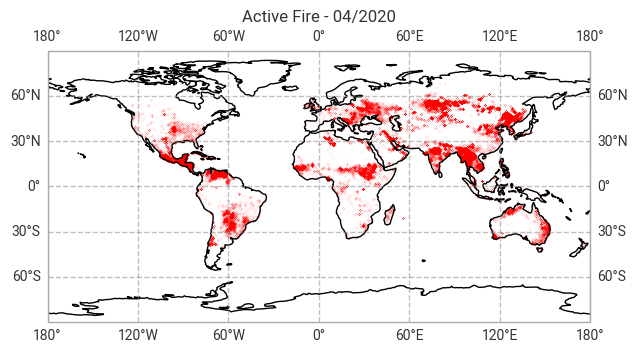

In [6]:
title = 'Active Fire - 04/2020'

ax = plt.axes(projection=ccrs.PlateCarree())
# We can now plot the data using the inbuilt geopandas plot function:
fig = frp_summary_df_geo.plot(ax=ax, color='red', marker='.', markersize=0.001)
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top=False
ax.coastlines()
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_title(title)

#### Active Fire & Fire Radiative Power gridded products

Now we'll take a look at the gridded data product and plot an example for April 2020.
The following cell will request and download the gridded (0.25°x0.25°), monthly aggregated, Active Fire and Fire Radiative Power products for April 2020.

In [ ]:
gridded_data_file = f"{DATADIR}/frp_month_202004.zip"

request = {
    "variable": "all",
    "product_type": "gridded",
    "time_aggregation": "month",
    "horizontal_aggregation": "0_25_degree_x_0_25_degree",
    "year": "2020",
    "month": ["04"],
    "day": ["01"],
    "version": ["1_0"]
}

if not os.path.exists(gridded_data_file):
    c.retrieve(dataset, request).download(target=gridded_data_file)

# We then open this downloaded file with EarthKit 
frp_data_042020 = ek.data.from_source("file", gridded_data_file)

Now we can use earthkit to convert the data to an xarray object and inspect the contents. The output of the cell below shows the data in an Xarray.Dataset format. You can explore the data variables, their dimensionality and any attributes attached.

In [8]:
data_frp_all_month = frp_data_042020.to_xarray()
data_frp_all_month

<xarray.Dataset> Size: 91MB
Dimensions:                                           (lon: 1440, lat: 720,
                                                       time: 1, bounds: 2)
Coordinates:
  * lon                                               (lon) float32 6kB -179....
  * lat                                               (lat) float32 3kB 89.88...
  * time                                              (time) datetime64[ns] 8B ...
Dimensions without coordinates: bounds
Data variables: (12/17)
    lon_bounds                                        (lon, bounds) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    lat_bounds                                        (lat, bounds) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bounds                                       (time, bounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    s3a_night_fire                                    (time, lat, lon) float64 8MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_frp                                     (time, lat, lon) float32 4MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_pixel                                   (time, lat, lon) float64 8MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    ...                                                ...
    s3b_night_FRP_related_surface_conditions_flag     (time, lat, lon) float64 8MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_FRP_related_atmospheric_condition_flag  (time, lat, lon) float64 8MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_fire_weighted                           (time, lat, lon) float32 4MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_fire_weighted                           (time, lat, lon) float32 4MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
Attributes: (12/39)
    title:                      ECMWF C3S Gridded OLCI Fire Radiative Power p...
    institution:                King's College London, Brockmann Consult GmbH
    source:                     ESA Sentinel-3 A+B SLSTR FRP
    history:                    Created on 20210325T075328Z
    references:                 See https://climate.copernicus.eu/
    tracking_id:                f25465fd-dd1a-44da-9b5c-9093ec610e44
    ...                         ...
    sensor:                     SLSTR
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

Now we will plot the total night time fire radiative power for the month of April. First, we define a colormap for visualising the Fire Radiative Power data.

In [9]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap([
    ( 49/256.,  57/256., 149/256.),    # <1         # <5
    ( 57/256.,  94/256., 196/256.),    # 1-5        # 5-10
    ( 96/256., 143/256., 204/256.),    # 5-10       # 10-25
    (171/256., 217/256., 233/256.),    # 10-25      # 25-50
    (255/256., 255/256., 191/256.),    # 25-50      # 50-100
    (253/256., 174/256.,  97/256.),    # 50-100     # 100-250
    (215/256.,  48/256.,  39/256.),    # 100-200    # 250-500
    (165/256.,   0/256.,  38/256.),    # 200-300    # 500-750
    (135/256.,   0/256.,   0/256.),    # >300       # >750
])

bounds = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N) 

Text(0.5, 1.0, 'Total Fire Radiative Power - S3A - Night-Time - 2020-04-01')

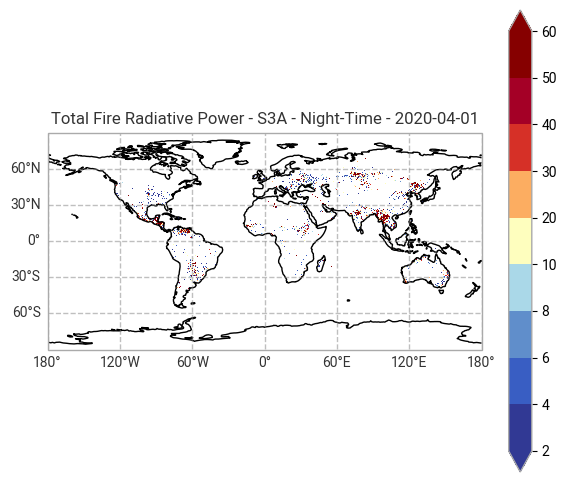

In [10]:
plot_date = '2020-04-01'

data_frp_month_2D=data_frp_all_month['s3a_night_frp']
data_fire_month_2D=data_frp_all_month['s3a_night_fire']
# Calculate the total FRP for the month as the product of the mean FRP and the number of fires
data_total_frp_month_2D = data_frp_month_2D * data_fire_month_2D

# Set plot title
title = f'Total Fire Radiative Power - S3A - Night-Time - {plot_date}'

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())
data_total_frp_month_2D.sel(time=plot_date).plot(cmap=cmap, norm=norm)
ax.gridlines(
    draw_labels=["bottom", "left"], linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
ax.coastlines()
ax.set_title(title)

#### Other projection

Let's visualise the April of the year 2020 once again, but in a different projection!

Text(0.5, 1.0, 'Total Fire Radiative Power - S3A - Night-Time - 2020-04-01')

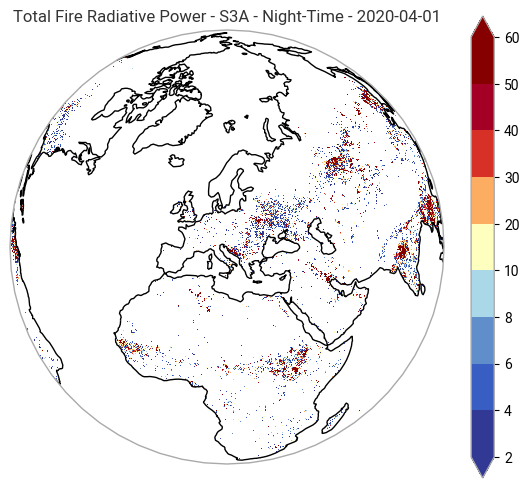

In [11]:
ax = plt.axes(projection=ccrs.Orthographic(15, 45))
ax.set_global()
data_total_frp_month_2D[0].plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )
ax.coastlines()
plt.title(title)

## Time Series

### Active Fire & Fire Radiative Power gridded products

We will now download a longer time-period and extract the data for a given location and plot a time-series.

In [ ]:
frp_gridded_data_multiple_month_file = f"{DATADIR}/frp_month_03_12_2020.zip"
request = {
    "variable": "all",
    "product_type": "gridded",
    "time_aggregation": "month",
    "horizontal_aggregation": "0_25_degree_x_0_25_degree",
    "year": "2020",
    "month": [
        "03", "04", "05",
        "06", "07", "08",
        "09", "10", "11",
        "12"
    ],
    "day": ["01"],
    "version": ["1_0"]
}

if not os.path.exists(frp_gridded_data_multiple_month_file):
    c.retrieve(dataset, request).download(target=frp_gridded_data_multiple_month_file)

# We then open this downloaded file with EarthKit 
frp_gridded_data_multiple_month = ek.data.from_source("file", frp_gridded_data_multiple_month_file)

First we convert the earthkit object to an xarray.Dataset. The output of the cell below shows the data as an xarray.Dataset, you can see that we have 10 time steps corresponding to the months from February to December of 2020

In [13]:
data_grid=frp_gridded_data_multiple_month.to_xarray()
data_grid

<xarray.Dataset> Size: 913MB
Dimensions:                                           (time: 10, lon: 1440,
                                                       bounds: 2, lat: 720)
Coordinates:
  * lon                                               (lon) float32 6kB -179....
  * lat                                               (lat) float32 3kB 89.88...
  * time                                              (time) datetime64[ns] 80B ...
Dimensions without coordinates: bounds
Data variables: (12/17)
    lon_bounds                                        (time, lon, bounds) float32 115kB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    lat_bounds                                        (time, lat, bounds) float32 58kB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    time_bounds                                       (time, bounds) datetime64[ns] 160B dask.array<chunksize=(1, 2), meta=np.ndarray>
    s3a_night_fire                                    (time, lat, lon) float64 83MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_frp                                     (time, lat, lon) float32 41MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_pixel                                   (time, lat, lon) float64 83MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    ...                                                ...
    s3b_night_FRP_related_surface_conditions_flag     (time, lat, lon) float64 83MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_FRP_related_atmospheric_condition_flag  (time, lat, lon) float64 83MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 41MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 41MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3a_night_fire_weighted                           (time, lat, lon) float32 41MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
    s3b_night_fire_weighted                           (time, lat, lon) float32 41MB dask.array<chunksize=(1, 45, 1440), meta=np.ndarray>
Attributes: (12/39)
    title:                      ECMWF C3S Gridded OLCI Fire Radiative Power p...
    institution:                King's College London, Brockmann Consult GmbH
    source:                     ESA Sentinel-3 A+B SLSTR FRP
    history:                    Created on 20210325T072251Z
    references:                 See https://climate.copernicus.eu/
    tracking_id:                047362b6-a953-4c05-857b-e908ba2c3386
    ...                         ...
    sensor:                     SLSTR
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

Now we extract the point data and plot as a time series

Text(0.5, 1.0, 'Total Fire Radiative Power - S3A - Night-Time - Point lat:27.7 lon:84.58')

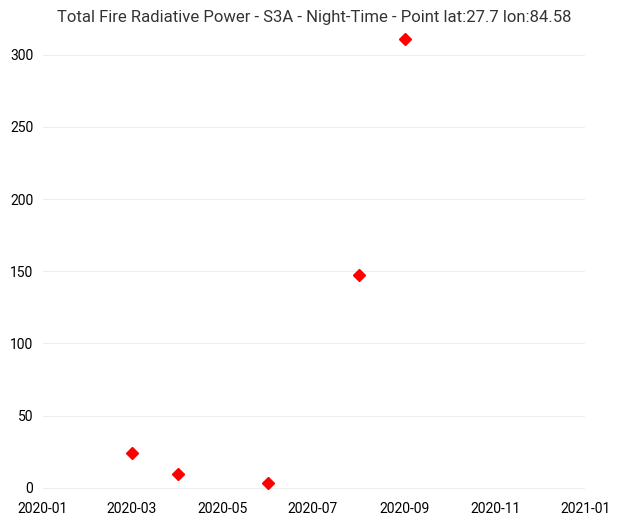

In [14]:
# Point selection 
lat = 27.70 # 43.0
lon = 84.58 # 75.0

data_grid_subset = data_grid.sel(lat=lat, lon=lon, method='nearest')
data_total_frp_timeseries=data_grid_subset['s3a_night_frp'] * data_grid_subset['s3a_night_fire']

title = 'Total Fire Radiative Power - S3A - Night-Time'
data_total_frp_timeseries.coords['time'].values
# Create the figure
fig, ax = plt.subplots()
ax.plot(
    data_total_frp_timeseries.coords['time'].values, data_total_frp_timeseries,
    marker="D", linestyle='None', color ='red'
)
ax.set_xlim(np.datetime64('2020-01'), np.datetime64('2021-01'))

ax.set_title(title + ' - Point lat:' + str(lat) + ' lon:' + str(lon))


## Fire Season

“The start, end and duration of a regions fire season can be calculated in different ways, including via thresholding the cumulative FRP distribution that essentially brackets the continuous time of year that an area experiences the majority of fire activity (see Freeborn et al., 2014). Here we produce the cumulative distribution of FRP generated by night-time fires burning in Australia, expressing this as a % of the annual total. From such a graph, the fire season start and end can be easily identified – for example as the times when the 10th and 90th percentiles of the cumulative distribution of FRP are reached. The fire season duration is the time between these dates, and in future such data might be used for example to test whether fire season lengths appear to be changing – potentially in response to a changing climate (e.g. Silva et al., 2022).”


First we will loop over the months March to December 2021 and download daily aggregated data.

In [ ]:
base_request = {
    "variable": "all",
    "product_type": "gridded",
    "time_aggregation": "day",
    "horizontal_aggregation": "0_1_degree_x_0_1_degree",
    "year": "2020",
    "month": ["03"],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",  
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": ["1_0"]
}

download_files = []
for month in [f"{i:02d}" for i in range(3, 13)]:
    download_file = f"{DATADIR}/frp_gridded_2020{month}.zip"
    download_files.append(download_file)
    if not os.path.exists(download_file):
        request = base_request.copy()
        request["month"] = [month]
        c.retrieve(dataset, request).download(target=download_file)


We can then use earthkit-data to open all our files into a single xarray object, which will slice to our area of interest. The output of the cell below shows the xarray.Dataset of the Fire Radiative Power product, subset over Australia.

In [16]:
# Spatial subset selection - Australia
min_lon = 110
min_lat = -10
max_lon = 155
max_lat = -40

frp_gridded_data_2020 = ek.data.from_source("file", download_files)
data_grid_2020 = frp_gridded_data_2020.to_xarray()

data_grid_2020 = data_grid_2020.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

data_grid_2020

<xarray.Dataset> Size: 4GB
Dimensions:                                           (time: 306, lon: 450,
                                                       bounds: 2, lat: 300)
Coordinates:
  * lon                                               (lon) float32 2kB 110.1...
  * lat                                               (lat) float32 1kB -10.0...
  * time                                              (time) datetime64[ns] 2kB ...
Dimensions without coordinates: bounds
Data variables: (12/19)
    lon_bounds                                        (time, lon, bounds) float32 1MB dask.array<chunksize=(1, 450, 2), meta=np.ndarray>
    lat_bounds                                        (time, lat, bounds) float32 734kB dask.array<chunksize=(1, 300, 2), meta=np.ndarray>
    time_bounds                                       (time, bounds) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    s3a_night_fire                                    (time, lat, lon) float64 330MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3a_night_frp                                     (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3a_night_frp_unc                                 (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    ...                                                ...
    s3b_night_FRP_related_surface_conditions_flag     (time, lat, lon) float64 330MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3b_night_FRP_related_atmospheric_condition_flag  (time, lat, lon) float64 330MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3a_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3b_night_related_atmospheric_condition_fraction  (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3a_night_fire_weighted                           (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
    s3b_night_fire_weighted                           (time, lat, lon) float32 165MB dask.array<chunksize=(1, 8, 450), meta=np.ndarray>
Attributes: (12/39)
    title:                      ECMWF C3S Gridded OLCI Fire Radiative Power p...
    institution:                King's College London, Brockmann Consult GmbH
    source:                     ESA Sentinel-3 A+B SLSTR FRP
    history:                    Created on 20210325T065258Z
    references:                 See https://climate.copernicus.eu/
    tracking_id:                c7854f27-0c49-48f4-a17b-8b0c948ae900
    ...                         ...
    sensor:                     SLSTR
    spatial_resolution:         0.1 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.1
    geospatial_lat_resolution:  0.1

We then calculate the cumulative sum of the Night-time Fire Radiative Power over the Australian region of interest, as a percentage of the total Night-time Fire Radiative Power for the whole time period.

In [ ]:
# Calculate the total FRP
data_grid_2020['s3a_night_total_frp'] = data_grid_2020['s3a_night_frp'] * data_grid_2020['s3a_night_fire']

# Sum the data set via the dimensions lat, lon and time for the selected variables
data_total_frp_yearly = data_grid_2020['s3a_night_total_frp'].sum(dim=["lat", "lon", "time"], skipna=True).compute()

# Sum the data in the lat and lon dimensions to create our time series dataset
data_total_frp_timeseries = data_grid_2020['s3a_night_total_frp'].sum(dim=["lat", "lon"], skipna=True).compute()

# Calculate cumulative FRP in the time dimension
data_total_frp_cumulative_timeseries = data_total_frp_timeseries.cumsum(dim='time')

# We convert this to a percentage of the total FRP for the time-period, and updte the units
data_total_frp_cumulative_timeseries_percent = data_total_frp_cumulative_timeseries *100 / data_total_frp_yearly
data_total_frp_cumulative_timeseries_percent = data_total_frp_cumulative_timeseries_percent.assign_attrs(
    units='%'
)
data_total_frp_cumulative_timeseries_percent.to_dataset()


<xarray.Dataset> Size: 5kB
Dimensions:              (time: 306)
Coordinates:
  * time                 (time) datetime64[ns] 2kB 2020-03-01 ... 2020-12-31
Data variables:
    s3a_night_total_frp  (time) float64 2kB 0.02114 0.02928 ... 99.96 100.0

Finally we plot the cummulative time-series of the FRP over Australia for March to December 2020

Text(0.5, 1.0, 'Total Fire Radiative Power - S3A - Night-Time - Australia')

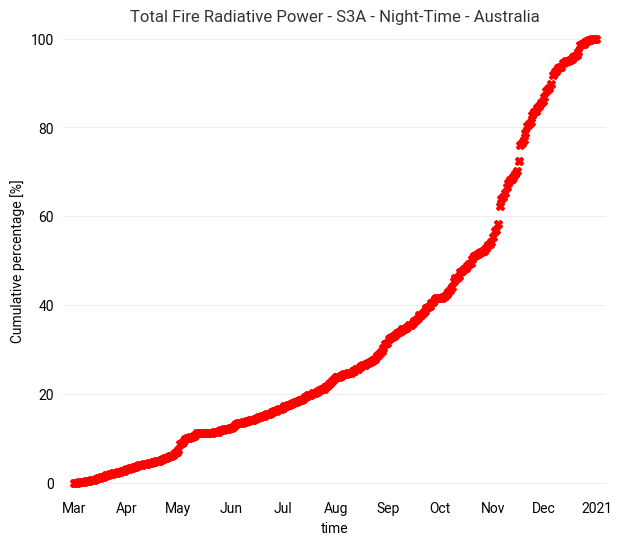

In [ ]:
title = 'Total Fire Radiative Power - S3A - Night-Time - Australia'
# Create the figure
fig_time, ax_time = plt.subplots()
data_total_frp_cumulative_timeseries_percent.plot(ax=ax_time, marker="X", linestyle='None', color ='red')
ax_time.set_ylabel("Cumulative percentage [%]")
ax_time.set_title(title)

## Take home messages 📌

The timeseries of the total global daily FRP of the products C3S  (AF & FRP) shows the fire season for Australia.

📌 **Note**: This tutorial shows how the C3S Sentinel-3 AF &FRP products can be downloaded and visualised, as well as subsetted, analysed and saved. In addition, one other aspect - fire season - is also shown.